In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

from scipy import sparse
from scipy import io

import scanpy as sc

In [2]:
# cd /central/groups/mthomson/jialong/single_cell/spin_spatial

/central/groups/mthomson/jialong/single_cell/spin_spatial


In [16]:
cur_samp = 'rep2'
mtx_file_path = '20230728_breast_cancer_10x/raw_data/' + cur_samp + '/matrix.mtx.gz'
gene_matrix = io.mmread(mtx_file_path)
gene_matrix = gene_matrix.T.tocsr().astype(np.uint16)

In [17]:
meta_file_path = '20230728_breast_cancer_10x/raw_data/' + cur_samp + '/cells.csv.gz'
cell_info = pd.read_csv(meta_file_path)

In [18]:
gene_matrix.shape

(118752, 541)

In [19]:
feature_filt_path =  '20230728_breast_cancer_10x/raw_data/' + cur_samp + '/features.tsv.gz'

gene_list = pd.read_csv(feature_filt_path, sep='\t', header=None)

gene_list.columns = ['gene_ENSG', 'gene_name', 'gene_type']
gene_list

,gene_ENSG,gene_name,gene_type
0,ENSG00000121270,ABCC11,Gene Expression
1,ENSG00000107796,ACTA2,Gene Expression
2,ENSG00000163017,ACTG2,Gene Expression
3,ENSG00000168615,ADAM9,Gene Expression
4,ENSG00000123146,ADGRE5,Gene Expression
...,...,...,...
536,BLANK_0487,BLANK_0487,Blank Codeword
537,BLANK_0488,BLANK_0488,Blank Codeword
538,BLANK_0489,BLANK_0489,Blank Codeword
539,BLANK_0497,BLANK_0497,Blank Codeword


In [20]:
cadata = ad.AnnData(X=gene_matrix, obs=cell_info, var=gene_list)
cadata.obs_names = cur_samp + '_' + cadata.obs['cell_id'].astype(str)
cadata.var_names = cadata.var['gene_name']

cadata.obs['batch'] = cur_samp

/home/jjiang3/miniconda3/envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.
/home/jjiang3/miniconda3/envs/scvi/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
cadata

AnnData object with n_obs × n_vars = 118752 × 541
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'batch'
    var: 'gene_ENSG', 'gene_name', 'gene_type'

In [15]:
cadata1 = cadata.copy()

In [22]:
cadata2 = cadata.copy()

In [23]:
cadata = cadata1.concatenate(cadata2, batch_key=None, index_unique=None)

/home/jjiang3/miniconda3/envs/scvi/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [24]:
cadata

AnnData object with n_obs × n_vars = 286532 × 541
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'batch'
    var: 'gene_ENSG', 'gene_name', 'gene_type'

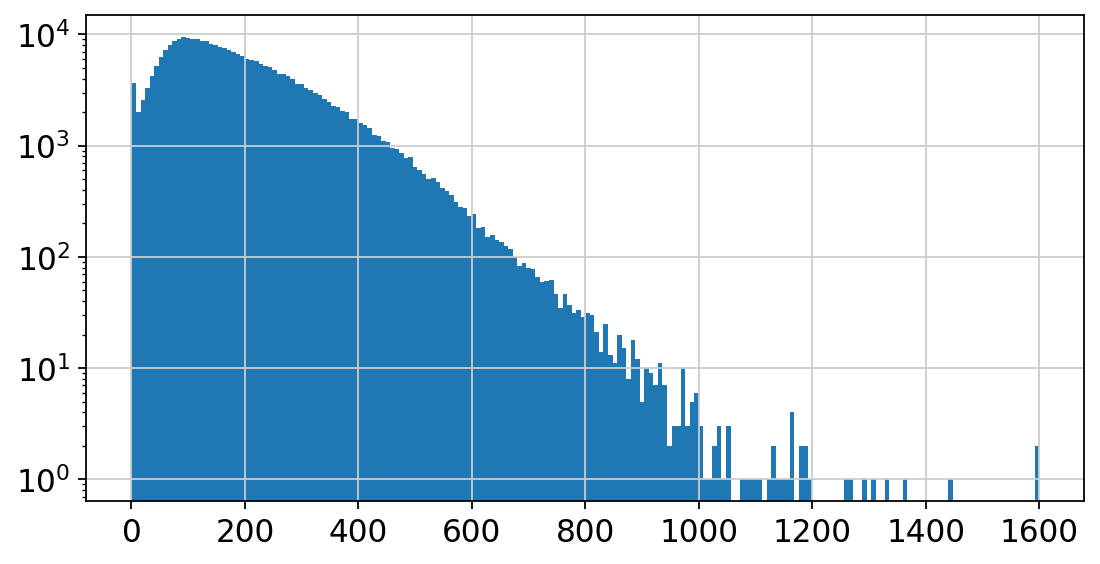

In [32]:
sc.set_figure_params(figsize=(8, 4))

plt.hist(cadata.obs['total_counts'], bins=200);
plt.yscale('log')

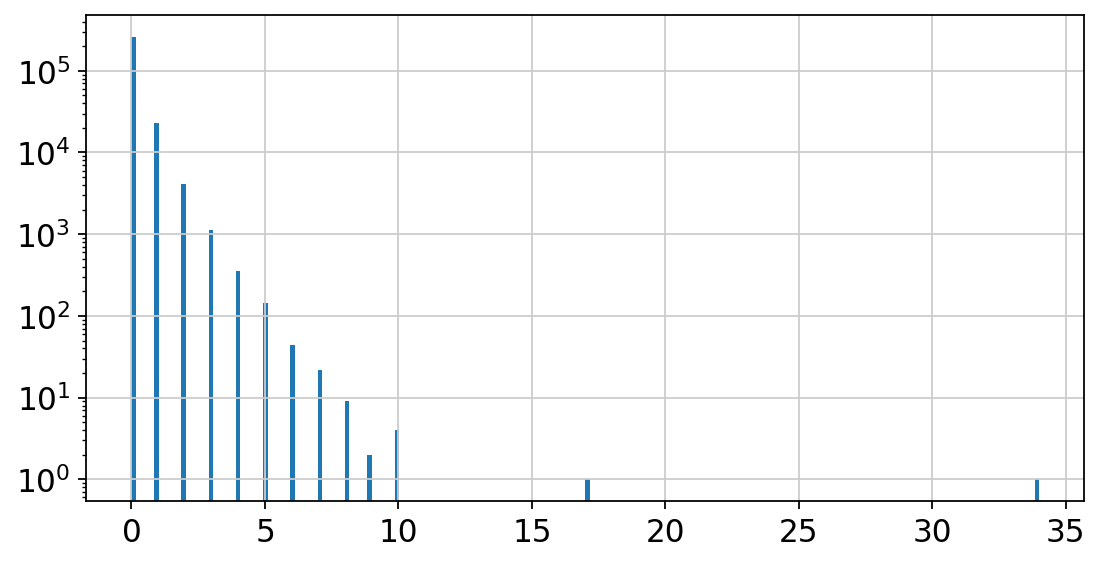

In [35]:
sc.set_figure_params(figsize=(8, 4))

plt.hist(cadata.obs['control_probe_counts'], bins=200);
plt.yscale('log')

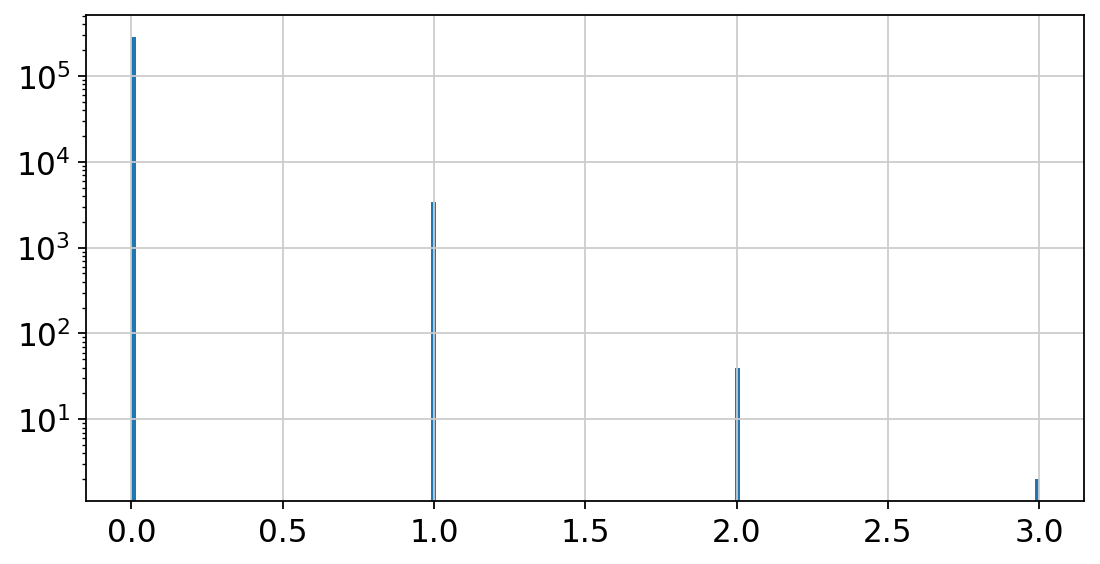

In [36]:
sc.set_figure_params(figsize=(8, 4))

plt.hist(cadata.obs['control_codeword_counts'], bins=200);
plt.yscale('log')

In [40]:
cell_filt = (cadata.obs['total_counts'] >= 50) & (cadata.obs['control_probe_counts'] < 5)
np.sum(cell_filt)

263903

In [41]:
gene_filt = cadata.var['gene_type'] == 'Gene Expression'
np.sum(gene_filt)

313

In [42]:
cadata = cadata[cell_filt][:, gene_filt]

In [43]:
cadata

View of AnnData object with n_obs × n_vars = 263903 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'batch'
    var: 'gene_ENSG', 'gene_name', 'gene_type'

In [44]:
cadata.layers["counts"] = cadata.X.copy()
sc.pp.normalize_total(cadata)

In [48]:
np.median(np.array(np.sum(cadata.layers['counts'], axis=1)))

177.0

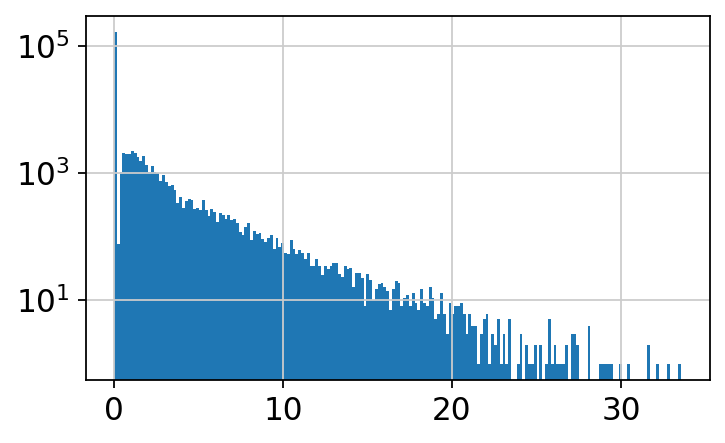

In [49]:
test_data = cadata.X[: 1000, : 200]
sc.set_figure_params(figsize=[5, 3])

plt.hist(test_data.toarray().flatten(), bins=200);
plt.yscale('log')

In [60]:
sc.pp.log1p(cadata)

In [67]:
sc.pp.pca(cadata)

In [68]:
sc.pp.neighbors(cadata)

In [69]:
sc.tl.leiden(cadata)

In [70]:
sc.tl.umap(cadata)

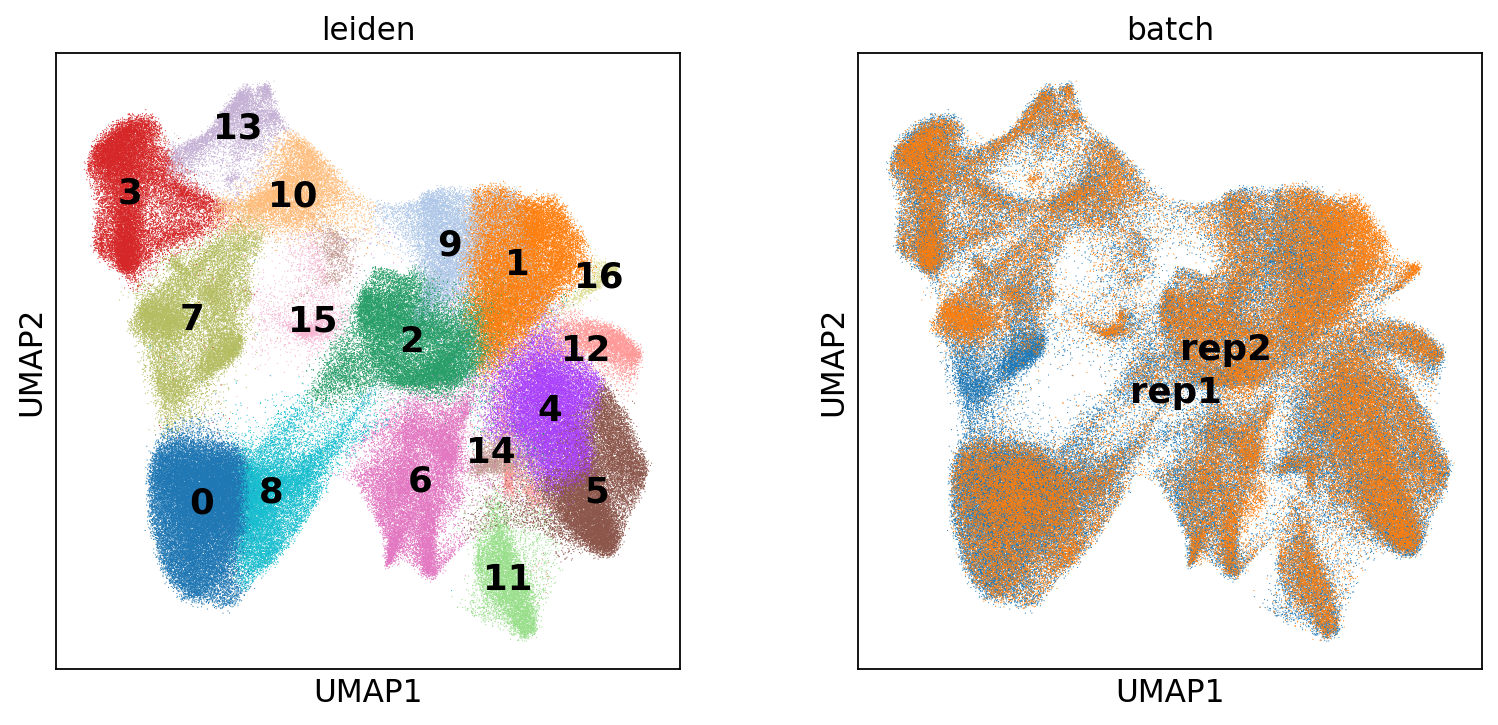

In [79]:
sc.set_figure_params(figsize=[5, 5])

sc.pl.umap(cadata, color=['leiden', 'batch'], legend_loc='on data', size=1, legend_fontsize=16)

In [72]:
cadata.obs['leiden'].unique()

['7', '15', '0', '10', '3', ..., '11', '12', '1', '13', '16']
Length: 17
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

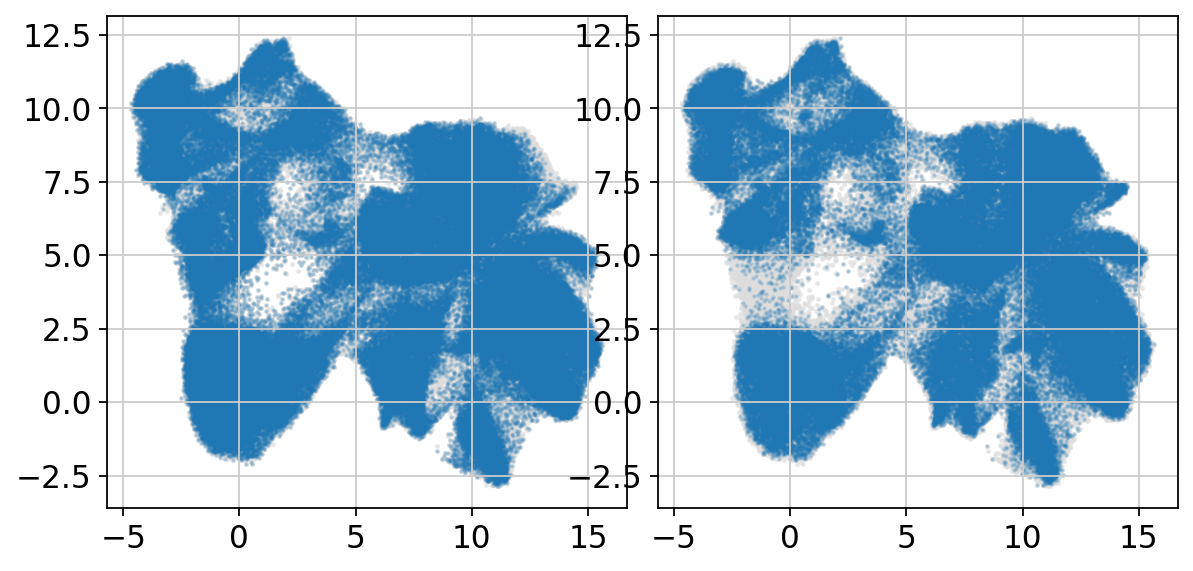

In [73]:
sc.set_figure_params(figsize=[4, 4])
fig, grid = sc.pl._tools._panel_grid(0.2, 0.06, ncols=3, num_panels=3)

for ii, cbatch in enumerate(['rep1', 'rep2']):
    ax = plt.subplot(grid[ii])
    cur_filt = (cadata.obs['batch'] == cbatch)
    plt.scatter(cadata.obsm['X_umap'][:, 0], cadata.obsm['X_umap'][:, 1], color='#dddddd', alpha=0.5, s=2)
    plt.scatter(cadata.obsm['X_umap'][cur_filt, 0], cadata.obsm['X_umap'][cur_filt, 1], s=1, alpha=0.2)

In [74]:
cadata.obs['leiden'].value_counts()

0     37673
1     27053
2     24248
3     24026
4     21300
5     21187
6     20486
7     19691
8     16242
9     13320
10     9606
11     8405
12     6963
13     6510
14     3387
15     2875
16      931
Name: leiden, dtype: int64

In [80]:
cadata.write('20230728_breast_cancer_10x/data/adata_combined.h5ad')

In [6]:
data_folder = '20230728_breast_cancer_10x/data/'

In [5]:
cadata = ad.read_h5ad('20230728_breast_cancer_10x/data/adata_combined.h5ad')

/home/jjiang3/miniconda3/envs/scvi/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jjiang3/miniconda3/envs/scvi/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
gene_annotation = pd.read_csv(data_folder + 'gene_annotation.csv')
gene_annotation

,Genes,Ensembl_ID,Num_Probesets,Codewords,Annotation
0,ABCC11,ENSG00000121270,7,1,Breast cancer
1,ACTA2,ENSG00000107796,8,1,Smooth muscle cells
2,ACTG2,ENSG00000163017,8,1,Breast myoepithelial cells
3,ADAM9,ENSG00000168615,8,1,Breast glandular cells
4,ADGRE5,ENSG00000123146,8,1,Dendritic cells
...,...,...,...,...,...
275,VWF,ENSG00000110799,8,1,Endothelial cells
276,WARS,ENSG00000140105,8,1,Endothelial cells
277,ZEB1,ENSG00000148516,8,1,Breast cancer
278,ZEB2,ENSG00000169554,8,1,Breast cancer


In [9]:
list_type = np.unique(gene_annotation['Annotation'])

In [37]:
np.array(list_type)

array(['Adipocytes', 'B cells', 'Breast cancer', 'Breast glandular cells',
       'Breast myoepithelial cells', 'Dendritic cells',
       'Endothelial cells', 'Epithelial cells', 'Fibroblasts',
       'Immune cells', 'Macrophages', 'Mast cells', 'Monocytes',
       'Myeloid cells', 'NK cells', 'Neutrophils', 'Plasma cells',
       'Smooth muscle cells', 'T cells'], dtype=object)

In [16]:
gene_select = []
gene_group_size = []

for ctype in list_type: 
    cur_gene = gene_annotation[gene_annotation['Annotation'] == ctype]['Genes']
    gene_select += list(cur_gene)
    gene_group_size.append(len(cur_gene))

In [39]:
gene_annotation[gene_annotation['Annotation'] == 'B cells']['Genes']

13      ANKRD28
16     APOBEC3A
24        BANK1
29      C2orf42
39        CCPG1
43         CD19
45         CD27
52        CD79A
53        CD79B
67       CLECL1
83       DNAAF1
90        DUSP5
97         ERN1
100     FAM107B
134       ITM2C
153      LGALSL
173       MS4A1
179        MZB1
196       PELI1
210       RAB30
223      SEC11C
232      SLAMF1
233      SLAMF7
253       TCL1A
269       TRIB1
274       VOPP1
Name: Genes, dtype: object

In [18]:
gene_select_ind = [list(cadata.var_names).index(gene) for gene in gene_select]

In [30]:
leiden_list = cadata.obs['leiden'].value_counts().index.tolist()

max_select = 1000
cell_order = []
group_size = []
for ii in range(len(leiden_list)):
    adata_sub = cadata[cadata.obs['leiden'] == leiden_list[ii], :]
    sele_thres = np.sort(adata_sub.obs['total_counts'])[::-1][min(max_select, len(adata_sub)) - 1]
    cell_order += np.where((cadata.obs['leiden'] == leiden_list[ii]) & (cadata.obs['total_counts'] >= sele_thres))[0].tolist()
    group_size.append(min(max_select, len(adata_sub)))

In [42]:
gene_zscore = (cadata.X - cadata.X.mean(axis=0)) / cadata.X.toarray().std(axis=0)
gene_zscore = np.array(gene_zscore).clip(- 4, 4)

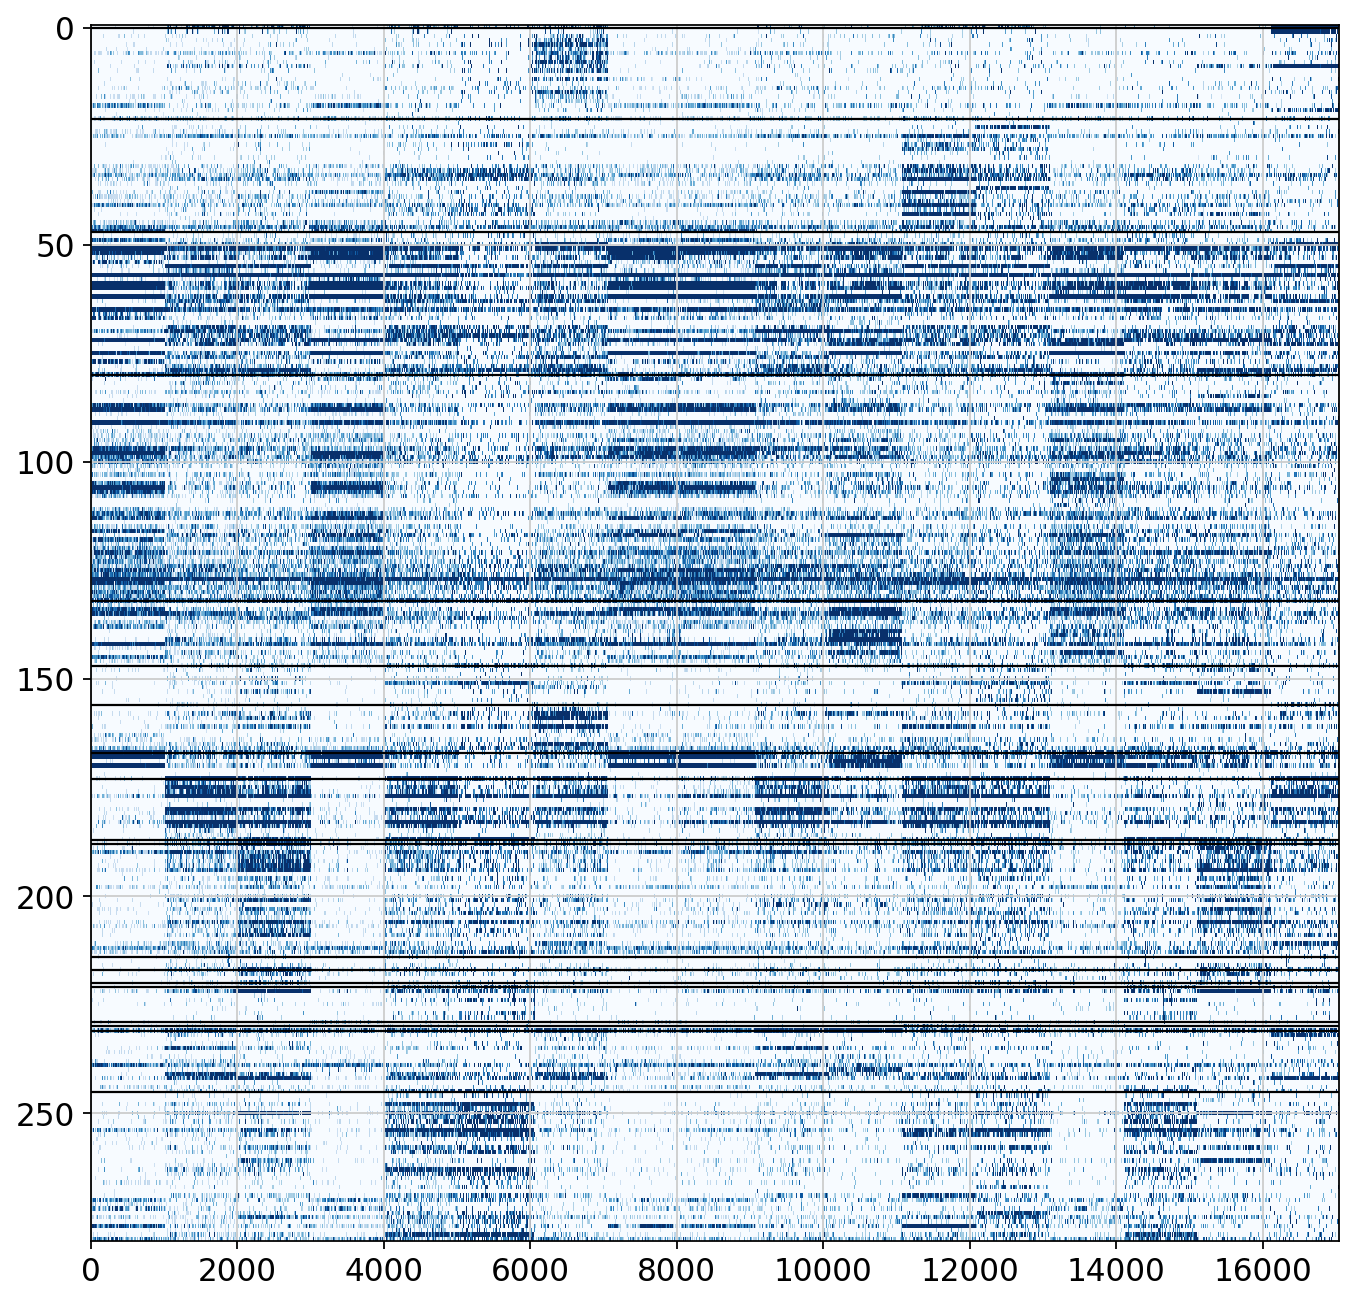

In [36]:
sc.set_figure_params(figsize=(10, 10))

plt.imshow(cadata.X[cell_order][:, gene_select_ind].toarray().T, cmap='Blues', aspect='auto', interpolation='none', vmax=1)

for ii in range(len(gene_group_size)):
    plt.axhline(np.sum(gene_group_size[:ii]), color='k', linewidth=1)

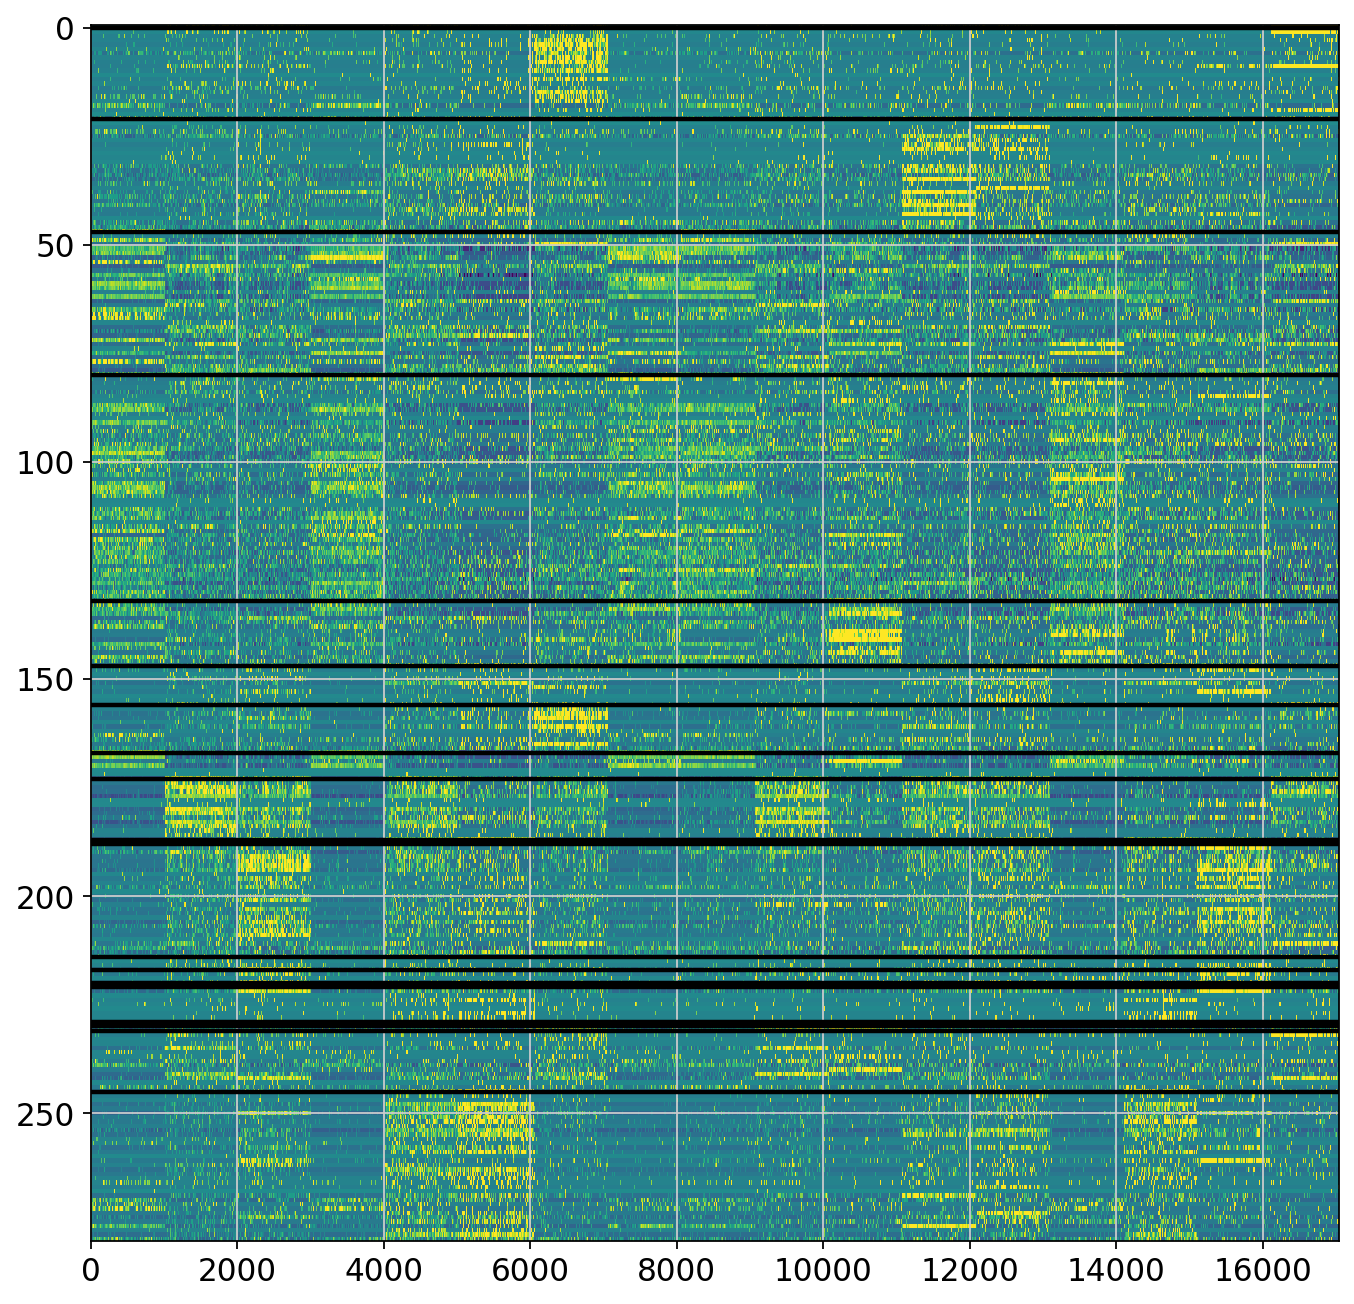

In [47]:
sc.set_figure_params(figsize=(10, 10))

plt.imshow(gene_zscore[cell_order][:, gene_select_ind].T, aspect='auto', interpolation='none', vmin=-2, vmax=2)

for ii in range(len(gene_group_size)):
    plt.axhline(np.sum(gene_group_size[:ii]), color='k', linewidth=2)